In [1]:
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import scipy, math
from scipy import stats
import jp_mpl as jplot

import rat_misc, jp_analysis
from scipy import optimize
import ROOT

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [2]:
data_dir = '/home/jpyanez/scratch/snoplus/water_analysis_tbin6_ntuple'
fname = 'Analysis_r0000108404_s002_p003.ntuple.root'
infile_name = os.path.join(data_dir, fname)

In [2]:
mcdir = '/home/jpyanez/scratch/snoplus/water_mc_tl208pmt_tbin6_ntuple'
fname = 'WaterTl208_PmtRun_r108281_s0_p0.ntuple.root'
infile_name = os.path.join(mcdir, fname)

In [8]:
mcdir = '/home/jpyanez/scratch/snoplus/full_ntuples/tb6_mc_bi214_ntuple'
fname = 'WaterBi214Run_r108405_s0_p1.ntuple.root'
infile_name = os.path.join(mcdir, fname)

In [9]:
tfile = ROOT.TFile(infile_name)

In [10]:
this_tree = tfile.Get('output')

In [11]:
this_tree

<ROOT.TTree object ("output") at 0x9a322c0>

In [13]:
branches =  this_tree.GetListOfBranches()

In [14]:
branches.ls()

In [56]:
all_conditions = ["nhitsCleaned >= 15",
                  "fitValid",
                  "waterFit",
                  "itr > 0.55",
                  "beta14 > -0.12",
                  "beta14 < 0.95"
                 ]
condition_string = " && ".join(all_conditions)
this_tree.Draw(">>analysis",  condition_string)


3479L

In [58]:
mylist = ROOT.gDirectory.Get("analysis")

In [60]:
this_tree.SetEventList(mylist)

In [61]:
outfile = '/home/jpyanez/scratch/snoplus/test/small.root'

In [62]:
f2 = ROOT.TFile(outfile, "recreate")

In [63]:
small = this_tree.CopyTree("");

In [64]:
small.Write()

6604

In [66]:
f2.Close()
tfile.Close()

In [71]:
new_file = ROOT.TFile(outfile)
new_tree = new_file.Get('output')

In [74]:
wfit = new_tree.GetBranch('waterFit')

In [75]:
wfit.GetEntries()

3479L

In [ ]:
# Analysis cuts
'''
vlozza [10:49 AM]
FitValid == 1, WaterFit == 1, ITR>0.55, -0.12 < beta14 < 0.95, nhitsCleaned ≥ 15, 
dataCleaning mask (according to RAT version)
energy, position, u.R depends on the analysis
'''





In [7]:
def arrayDiagnostics(values, name, ax_lim = [None, None]):
        print 'Diagnostics', name
        print values.min(),values.max(), values.mean()
        plt.figure()
        if ax_lim[0] == None:
            ax_lim[0] = 0.
        if ax_lim[1] == None:
            ax_lim[1] = np.median((values[values>0]))*10
        
        xaxis = np.linspace(ax_lim[0], ax_lim[1], 100)
        b, x = np.histogram(values, xaxis)

        jplot.unfilledBar(x,b)
        plt.yscale('log')
        plt.xlabel(name)

In [8]:
def dumpArray( tree, branch_name, show_info = False, ax_lim = [None, None]):
    branch = tree.GetBranch(branch_name)
    branch.GetEntry(2000)
    branch.GetLeaf(branch_name).GetValue(0)
    
    tot_entries = branch.GetEntries()
    values = np.zeros(tot_entries)
    for i in range(tot_entries):
        branch.GetEntry(i)
        values[i] = branch.GetLeaf(branch_name).GetValue(0)
    if show_info:
        arrayDiagnostics(values,branch_name, ax_lim)

    return values

Diagnostics nhitsCleaned
0.0 5850.0 5.99758011892


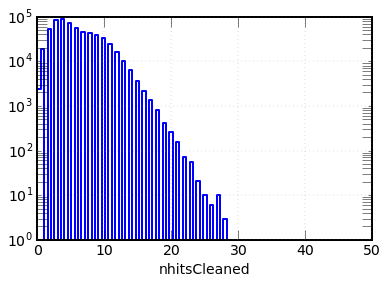

In [9]:
nhitsCleaned = dumpArray(this_tree, 'nhitsCleaned', True)

Diagnostics nhits
0.0 27.0 1.01903602726


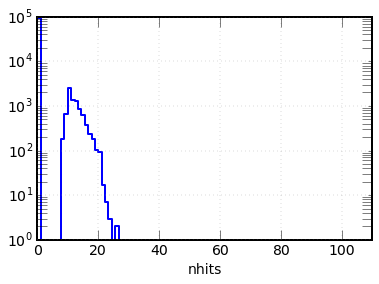

In [102]:
nhits = dumpArray(this_tree, 'nhits', True)

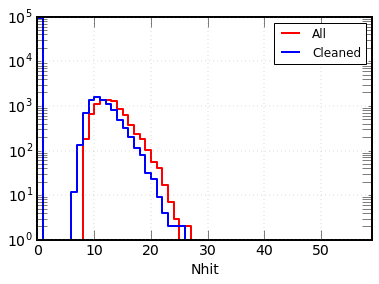

In [103]:
xaxis = np.arange(0, 60, 1)
nh, x = np.histogram(nhits, xaxis)
nhc, x = np.histogram(nhitsCleaned, xaxis)

jplot.unfilledBar(x,nh, color='red', label='All')
jplot.unfilledBar(x,nhc, color='blue', label='Cleaned')
plt.yscale('log')
plt.xlabel('Nhit')
plt.legend(loc=0)

Diagnostics qpdtProbability
-99999.0 1.0 -7298.85288533
Diagnostics qpdtNhitsEarly
-99999.0 8.0 -7298.841889
Diagnostics qpdtQMax
-99999.0 497.0 -7298.00630964


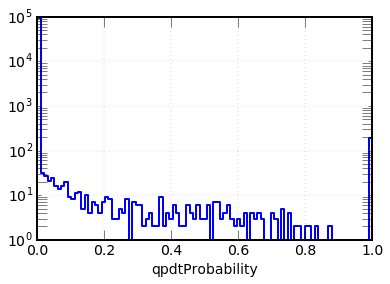

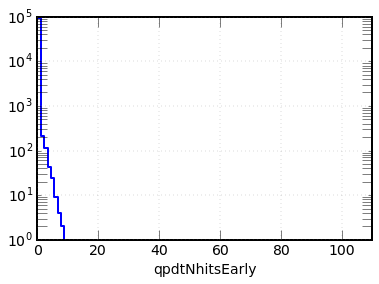

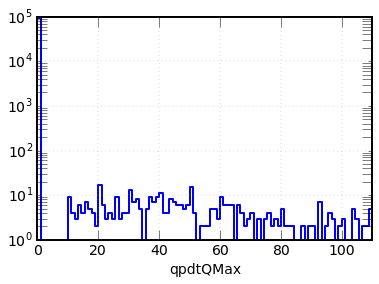

In [105]:
qpdtProbability = dumpArray(this_tree, 'qpdtProbability', True, [0,1])
qpdtNhitsEarly = dumpArray(this_tree, 'qpdtNhitsEarly', True)
qpdtQMax = dumpArray(this_tree, 'qpdtQMax', True)

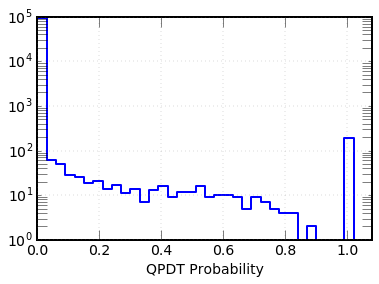

In [106]:
xaxis = np.arange(0, 1.1, 0.03)
qp, x = np.histogram(qpdtProbability, xaxis)

jplot.unfilledBar(x,qp)
plt.yscale('log')
plt.xlabel('QPDT Probability')

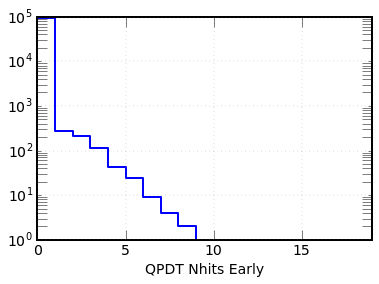

In [107]:
xaxis = np.arange(0, 20, 1)
qp, x = np.histogram(qpdtNhitsEarly, xaxis)

jplot.unfilledBar(x,qp)
plt.yscale('log')
plt.xlabel('QPDT Nhits Early')

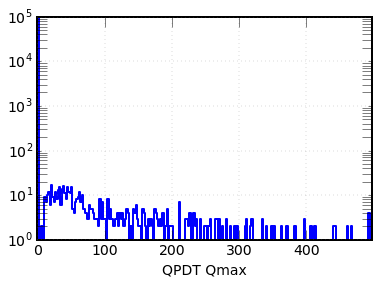

In [108]:
xaxis = np.arange(0, 500, 2)
qp, x = np.histogram(qpdtQMax, xaxis)

jplot.unfilledBar(x,qp)
plt.yscale('log')
plt.xlabel('QPDT Qmax')

Diagnostics QPDT Poisson CDF
0.0 1.0 0.920374322083
Diagnostics QPDT Poisson CDF
0.0 1.0 0.920374322083
The second hump is when Nearly = 0


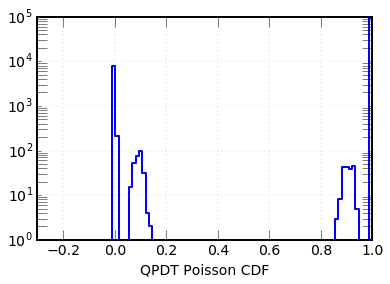

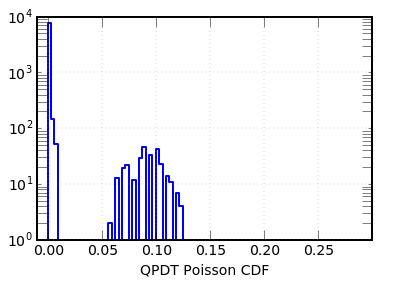

In [109]:
qpdtpos = stats.poisson.pmf(qpdtNhitsEarly, nhits*0.0062)

# My own recipe
#lam = 0.0062*nhits
#qpdtpos = lam**qpdtNhitsEarly * np.exp(-lam)/math.factorial(qpdtNhitsEarly)

arrayDiagnostics(qpdtpos, 'QPDT Poisson CDF', [-0.3, 1.])
arrayDiagnostics(qpdtpos, 'QPDT Poisson CDF', [-0.01, 0.3])
print 'The second hump is when Nearly = 0'

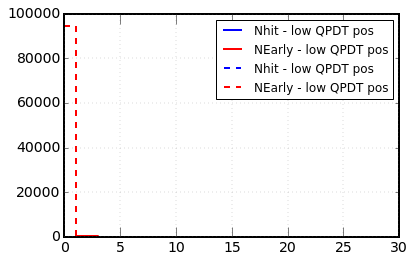

In [110]:
# Look for the source of the two distinct distributions. It's when Nearly = 0

qpdtbool = qpdtpos>0
bool2 = qpdtpos <0.5

# Need distributions of nearly and nhit
xaxis = np.arange(0, 31, 1)
nearl_low, x = np.histogram(qpdtNhitsEarly[qpdtbool*bool2], xaxis)
nhit_low, x = np.histogram(nhits[qpdtbool*bool2], xaxis)

jplot.unfilledBar(x, nhit_low, label='Nhit - low QPDT pos')
jplot.unfilledBar(x, nearl_low, color='red', label='NEarly - low QPDT pos')

nearl_high, x = np.histogram(qpdtNhitsEarly[qpdtbool*~bool2], xaxis)
nhit_high, x = np.histogram(nhits[qpdtbool*~bool2], xaxis)

jplot.unfilledBar(x, nhit_high, linestyle = '--', label='Nhit - low QPDT pos')
jplot.unfilledBar(x, nearl_high,  linestyle = '--', color='red', label='NEarly - low QPDT pos')
plt.legend(loc=0)

Diagnostics QDPT PQcor
-0.00103729302228 1.0 0.0747586381209


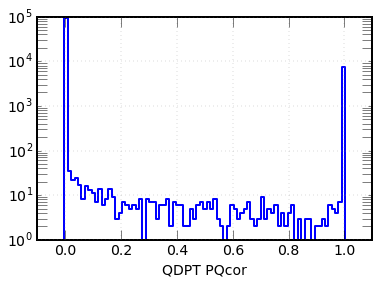

In [111]:
pqcor = 1-(1-qpdtProbability)**qpdtNhitsEarly
arrayDiagnostics(pqcor, 'QDPT PQcor', [-0.1,1.1])

In [112]:
pqpdt_pass = (qpdtNhitsEarly == 0) + ((pqcor > 0.01)*qpdtpos > 0.002)

In [113]:
print 'Passing fraction ', np.sum(pqpdt_pass)*1./pqpdt_pass.size

Passing fraction  0.923719571568


Diagnostics itr
-99999.0 0.9 -7298.85107507


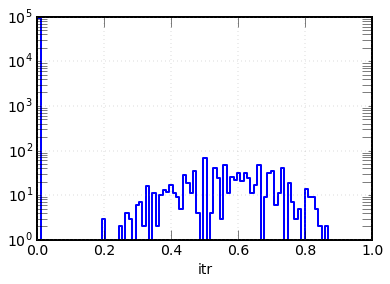

In [114]:
itr = dumpArray(this_tree, 'itr', True, [0, 1])


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


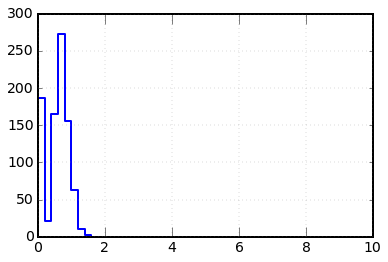

In [115]:
scaled_itr = itr*np.sqrt(qpdtNhitsEarly)
xaxis = np.linspace(0, 10, 51)
b, x = np.histogram(scaled_itr[itr>0], xaxis)
jplot.unfilledBar(x,b)

Diagnostics energy
-99999.0 6.24227845712 -603.684645354


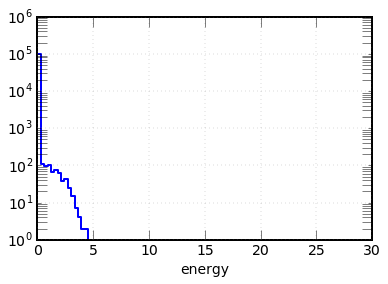

In [116]:
energy = dumpArray(this_tree, 'energy', True, [0, 30])

In [123]:
energybool = (energy>3.5)

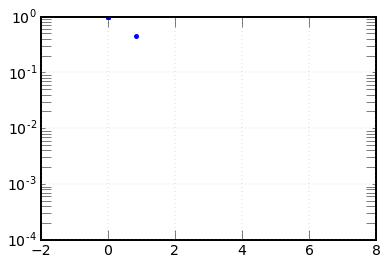

In [124]:
plt.plot(scaled_itr[energybool], qpdtProbability[energybool], '.')
plt.ylim(0.0001, 1.)
plt.xlim(-2, 8)
plt.yscale('log')